In [1]:

import networkx as nx
import graph_tool.all as gt
import glob
import ast
import gzip


def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    if isinstance(key, bytes):
        # Encode the key as ASCII
        key = key.encode('ascii', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, bytes):
        tname = 'string'
        value = value.encode('ascii', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

GROUPS =  ["RooibosTea_QR_1216_1646", "RooibosTea_QL_1216_1646", "MexHotChoc_QR_1216_1646", "MexHotChoc_QL_1216_1646", "20230213_1745_AlmdudlerGspritzt_C1", "20230213_1745_AlmdudlerGspritzt_C0", "20221209_1613_QR", "20221209_1613_QL", "20221123_1543_AmericanoLatte_QR", "20221123_1543_AmericanoLatte_QL"]

# Create a dictionary to store the graphs
graphs = {}

for group in GROUPS:
    files = glob.glob(f'/Users/wolf/git/queenright-queenless-analysis/raw_data/edgelists/raw/{group}*.edgelist.gz')
    group_graphs = {}

    # Create a set to store all nodes in the current group
    all_nodes_in_group = set()

    # Create an aggregate graph for the current group
    aggregate_graph = nx.DiGraph()

    for file in files:
        hour = file.split('_')[-1].split('.')[0]

        with gzip.open(file, 'rt') as f:
            lines = f.readlines()

        nxG = nx.DiGraph()

        for line in lines:
            data = line.strip().split(' ')
            node1 = data[0].split('.')[0]
            node2 = data[1].split('.')[0]
            
            all_nodes_in_group.add(node1)
            all_nodes_in_group.add(node2)
            edge_data = ast.literal_eval(' '.join(data[2:]))
            if "weight" not in edge_data:
                edge_data['weight'] = edge_data['count']
            nxG.add_edge(node1, node2, **edge_data)

            # Add the edge to the aggregate graph, summing the weights
            if aggregate_graph.has_edge(node1, node2):
                aggregate_graph[node1][node2]['weight'] += edge_data['weight']
            else:
                aggregate_graph.add_edge(node1, node2, **edge_data)

        group_graphs[int(hour)] = nxG

    # Add missing nodes to each graph in the current group
    for hour, graph in group_graphs.items():
        for node in all_nodes_in_group:
            if node not in graph.nodes():
                graph.add_node(node)

    # Convert the NetworkX graphs to graph-tool graphs
    for graph in group_graphs:
        group_graphs[graph] = nx2gt(group_graphs[graph])

    # Convert the aggregate graph to a graph-tool graph and add it to the group graphs
    group_graphs['aggregate'] = nx2gt(aggregate_graph)

    graphs[group] = group_graphs

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from matplotlib import colors
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

In [75]:

def calculate_metrics_and_visualize(g):
    # Calculate Betweenness Centrality
    vertex_betweenness, edge_betweenness = gt.betweenness(g)
    g.vertex_properties["vertex_betweenness"] = vertex_betweenness
    g.edge_properties["edge_betweenness"] = edge_betweenness

    # Calculate Closeness Centrality
    closeness = gt.closeness(g)
    g.vertex_properties["closeness"] = closeness

    # Community Detection (Louvain Method)
    state = gt.minimize_blockmodel_dl(g)
    blocks = state.get_blocks()
    g.vertex_properties["blocks"] = blocks

    # Prepare for visualization
    # Normalize betweenness for visualization purposes
    norm_vertex_betweenness = g.new_vertex_property("double")
    max_vertex_betweenness = max(vertex_betweenness.a)
    for v in g.vertices():
        norm_vertex_betweenness[v] = (vertex_betweenness[v] / max_vertex_betweenness) * 10  # Scaling for visibility
    
    return g, norm_vertex_betweenness, blocks


for group in GROUPS:
    g, nvb, blocks = calculate_metrics_and_visualize(graphs[group]['aggregate'])
    pos = gt.sfdp_layout(g)
    gt.graph_draw(g, pos, vertex_fill_color=nvb, vertex_size=gt.prop_to_size(nvb, mi=5, ma=15), output=f'../figures/aggregate_graph_{group}.png')


ValueError: zero-size array to reduction operation maximum which has no identity

53
55


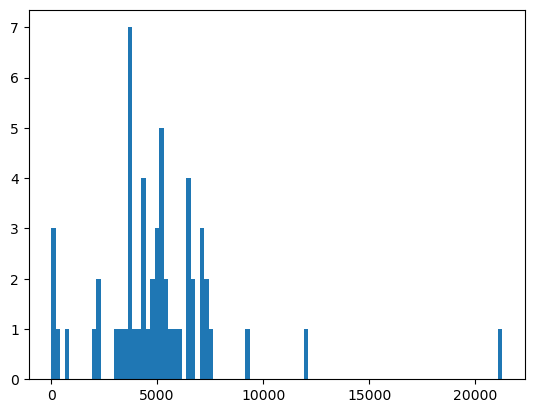

In [81]:
g = graphs['RooibosTea_QR_1216_1646']['aggregate'].copy()
min_weighted_degree = 10000

# Function to calculate the sum of weights of edges connected to a vertex
def weighted_degree_sum(v, weight):
    result = sum(weight[e] for e in v.out_edges()) + sum(weight[e] for e in v.in_edges())
    return result 

weighted_degree_sum_dist = [weighted_degree_sum(v, g.ep.count) for v in g.vertices()]
plt.hist(weighted_degree_sum_dist, bins=100)
# # Find all vertices with a weighted degree less than the threshold
vertices_to_remove = [v for v in g.vertices() if weighted_degree_sum(v, g.ep.count) < min_weighted_degree]

print(len(vertices_to_remove))
print(len(list(g.vertices())))